# Circulant Method

In [49]:
import numpy as np
import numpy.random as rd
import scipy.linalg as lalg
import matplotlib.pyplot as plt
import seaborn

In [104]:
# parameters
t = 1  ## we simulate on interval [0, T]
h = 0.25  ## Hurst exponant of our fractional gaussian movement

In order to simulate a Gaussian vector with mean $M$ and cov $C$ we recall that it can be represented as $M + SX$ where $X$ is a standard gaussian vector and $S$ is such that $SS^t = C$.
Thus, we need to generate a standard gaussian vector and such a "square root" matrix.

Our fractional Brownian motion (fBm) can be generated knowing only its increments and multiplying them by the regular time interval to the power $H$ : $(\frac{T}{n})^H$.


Its increments are stationary standard Gaussian variables that are defined by the following covariance fucntion: 

$\rho_H(n) = \mathbb{E}[\xi_1\xi_{n+1}] = \frac{1}{2}((n+1)^{2H}+(n-1)^{2H}-2n^{2H}),  n\geq1 $

Such a sequence of increments is called a fractional Gaussian noise (fGn).

In [105]:
# our covariance function
def cov(h, n):
    if n >= 1:
        return 0.5 * ((n + 1) ** (2 * h) + (n - 1) ** (2 * h) 
                      - 2 * n ** (2 * h))
    else:
        print("index 0 in cov function")
        return false
    
#vectorize it for further use
vec_cov = np.vectorize(cov)

With the preceding notations our covariance matrix is the following :

$
Cov(\xi) = 
\begin{pmatrix}
1 & \rho_H(1) & \rho_H(1) & \cdots & \rho_H(N-2) & \rho_H(N-1) \\
\rho_H(1) & 1 & \rho_H(1) & \cdots & \rho_H(N-3) & \rho_H(N-2) \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\rho_H(N-2) & \rho_H(N-3) & \rho_H(N-4) & \cdots & 1 & \rho_H(1) \\
\rho_H(N-1) & \rho_H(N-2) & \rho_H(N-3) & \cdots & \rho_H(1) & 1
\end{pmatrix}
$

In order to find a "square root" of $Cov(\xi)$ the circulant method proposes to find the square root of a bigger matrix. Define :
<br>
<br>
$M := 2(N-1)$
<br>
<br>
$c_k :=
\begin{cases}
1, & \text{if}\ k=0 \\
\rho_H(k), & \text{if}\ k=1,2,\cdots,N-1 \\
\rho_H(M-k), & \text{if} k = N,N+1,\cdots,M-1
\end{cases}
$

The matrix in question is circulant and defined as follows:
<br>
<br>
$ C = circ(c_0,c_1,\cdots,c_M-1) = 
\begin{pmatrix}
c_0 & c_1 & c_2 & \cdots & c_{M-2} & c_{M-1} \\
c_{M-1} & c_0 & c_1 & \cdots & c_{M-3} & c_{M-2} \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
c_2 & c_3 & c_4 & \cdots & c_0 & c_1 \\
c_1 & c_2 & c_3 & \cdots & c_{M-1} & c_0
\end{pmatrix} 
$
<br>
<br>
We shall now define those parameters and compute the circulant coefficients.

In [106]:
# exponent for the number of simulations
q = 11
# sample size and circulant matrix size
n = 2 ** q + 1
m = 2 ** (q + 1)

In [107]:
#circulant coefficients
index = np.arange(1, m)
coefs = np.zeros(m)
coefs[0] = 0
coefs[1:n + 1] = vec_cov(h, index[:n])
coefs[n + 1:] = vec_cov(h, m - index[n:])

Taking the root of such a Matrix can be done using a scaled discrete Fourier transform (DFT) represented by the matrix $Q = (q_{jk})_{j,k=0}^{M-1}$, with
<br>
<br>
$$
\begin{equation}
q_{jk} = \frac{1}{\sqrt{M}}\exp{-2\pi i\frac{jk}{M}}
\end{equation}
$$

$Q^*$ then acts as the inverse DFT such that $Q^*Q = QQ^* = I_M $

It follows from standard DFT properties (<font color='red'>TO BE EXAMINED</font>) that: 
<br>
<br>
$C = QDQ^*$ where $D = diag(\lambda_0,\lambda_1,\cdots,\lambda_{M-1})$
<br>
<br>
with $\lambda_k = \Sigma_{j=0}^{M-1}c_j\exp{-2\pi i\frac{jk}{M}}$.
<br>
<br>
Consequently, $C=SS^*$ with $S=QD^{1/2}Q^*$, $D^{1/2}= diag(\lambda_0^{1/2},\lambda_1^{1/2},\cdots,\lambda_{M-1}^{1/2})$.
<br>
<br>
Let us now compute such a square root using the numpy and scipy libraries.

In [108]:
# circulant matrix NOT USED
lalg.circulant(coefs)

# fft matrix
# (COULD BE DONE USING FFT LIBRARY FROM NUMPY ---> FASTER?)

j = np.zeros((m, m))
j[1:, :] = np.ones((m - 1, m))
j = np.cumsum(j, axis=0)
k = np.zeros((m, m))
k[:, 1:] = np.ones((m, m - 1))
k = np.cumsum(k, axis=1)
q = 1 / np.sqrt(m) * np.exp(-2 * 1j * np.pi * (1 / m) * j * k)

In [109]:
# diagonal matrix with sqrt of eigenvalues
q_t = np.transpose(q)
eigen_complex = np.dot(q_t, coefs)
eigen = np.real(eigen_complex)
eigen[eigen < 0] = 0 # GET RID OF NEGATIVE VALUES TODO: FIX
eigen_sqrt = np.sqrt(eigen)
diag_sqrt = np.diag(eigen_sqrt)

In [110]:
# compute fractional noise then movement
x = rd.normal(size=m)
q_adj = np.conj(np.transpose(q))
s = np.dot(np.dot(q, diag_sqrt), q_adj)
fgn = np.real(np.dot(s, x)[:n])
fbm = np.cumsum(fgn * (1 / n) ** h)

In [111]:
fbm.mean()

0.0010225123973088268

(0, 0.25)

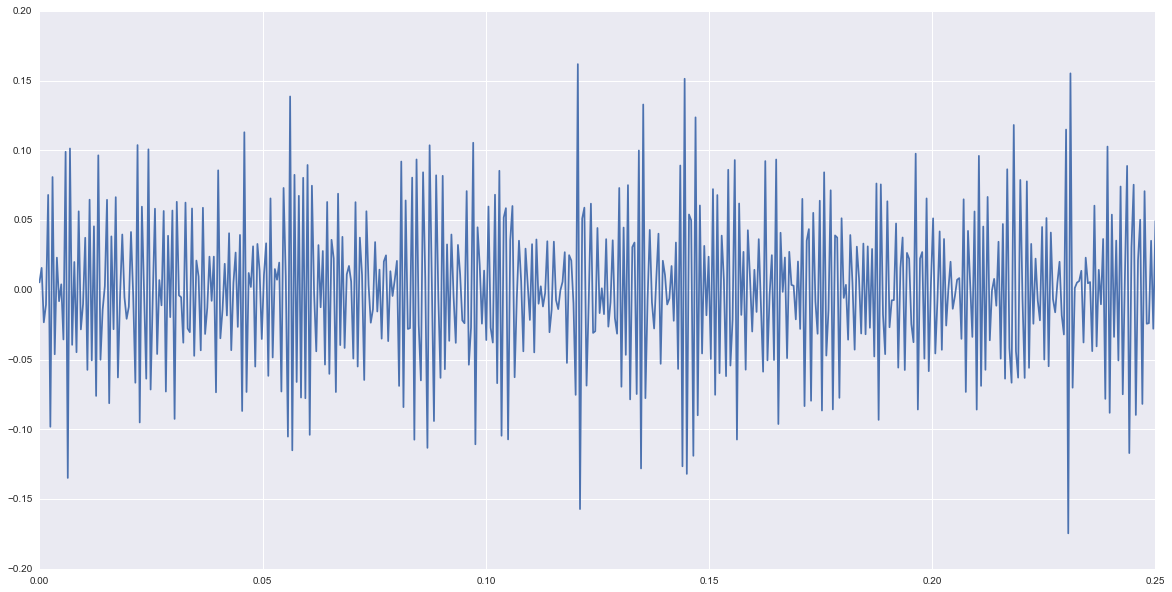

In [116]:
% matplotlib inline
times = np.linspace(0, 1, n)
plt.figure(figsize=(20,10))
plt.plot(times, fgn)
plt.xlim(0,0.25)